# 关于黑洞数据的预测

数据第一列是代表黑洞自旋值（输入参数），第二列代表距离，第三列代表频率，第四列代表速度 （二到四列只需选择其中一个作为输入参数即可，因为它们是相关的，知道其中任意一个，另外两个就知道了。具体选择哪一个作为输入参数，根据效果来定），最后两列是输出数据，分别是到达无穷远的能流和到达黑洞视界的能流，就是要通过训练，能让机器计算出来的值。

** 导入所需模块 **

In [1]:
import re
import numpy as np  
import pandas as pd  
import os
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

** 读取数据 **

In [2]:
if os.path.exists('buffer.txt'):
    with open('buffer.txt', 'w') as f:
        f.truncate()

def readbin(filename):
    file = open(filename)
    lines = file.readlines()
    
    outname = 'buffer.txt'
            
    with open(outname, 'a') as files:
        for line in lines:
            line = line.replace('D','E')
            files.write(line)
    file.close()

** 合并数据**

In [3]:
readbin('../DATA/tfluxlm_a09_nu0_100.dat')
readbin('../DATA/tfluxlm_a055_nu0_100.dat')
readbin('../DATA/tfluxlm_a075_nu0_100.dat')
readbin('../DATA/tfluxlm_a085_nu0_100.dat')

** 添加列名并写入csv **

In [4]:
def txtTocsv():
    filename = 'tfluxlm.csv'
    
    if os.path.exists(filename):
         with open(filename, 'w') as f:
            f.truncate()
        
    txt = np.loadtxt('buffer.txt')  
    txtDF = pd.DataFrame(txt)  
    txtDF.columns=['SpinValue','Dist','Frep','Velo','label1','label2']
    txtDF.to_csv(filename,index=False)  

In [5]:
txtTocsv()

** 读取合并后的数据 **

In [51]:
df = pd.read_csv('tfluxlm.csv')
df.head()

,SpinValue,Dist,Frep,Velo,label1,label2
0,0.9,156.201996,0.000512,0.080000,6.742594e-11,-1.756710e-16
1,0.9,137.429823,0.000620,0.085286,1.275639e-10,-4.590899e-16
2,0.9,121.847036,0.000743,0.090572,2.322062e-10,-1.132389e-15
3,0.9,108.769912,0.000881,0.095859,4.084749e-10,-2.653596e-15
4,0.9,97.688588,0.001035,0.101145,6.969423e-10,-5.940162e-15


** 画出各列的散点图 **

In [9]:
import matplotlib.pyplot as plt

def big():
    plt.figure(1)
    plt.title('SpinValue')
    plt.scatter(df.index,df['SpinValue'],c='black',marker='.')
    plt.figure(2)
    plt.title('Dist')
    plt.scatter(df.index,df['Dist'],c='blue',marker='.')
    plt.figure(3)
    plt.title('Frep')
    plt.scatter(df.index,df['Frep'],c='green',marker='.')
    plt.figure(4)
    plt.title('Velo')
    plt.scatter(df.index,df['Velo'],c='red',marker='.')
    plt.show()
def small():
    fig,axes=plt.subplots(3,2,figsize=(16,10))
    ax1=axes[0,0]
    ax2=axes[0,1]
    ax3=axes[1,0]
    ax4=axes[1,1]
    ax5=axes[2,0]
    ax6=axes[2,1]
    ax1.scatter(df.index,df['SpinValue'],c='black',marker='.')
    ax2.scatter(df.index,df['Dist'],c='blue',marker='.')
    ax3.scatter(df.index,df['Frep'],c='green',marker='.')
    ax4.scatter(df.index,df['Velo'],c='red',marker='.')
    ax5.scatter(df.index,df['label1'],c='red',marker='x')
    ax6.scatter(df.index,df['label2'],c='red',marker='x')
    plt.show()

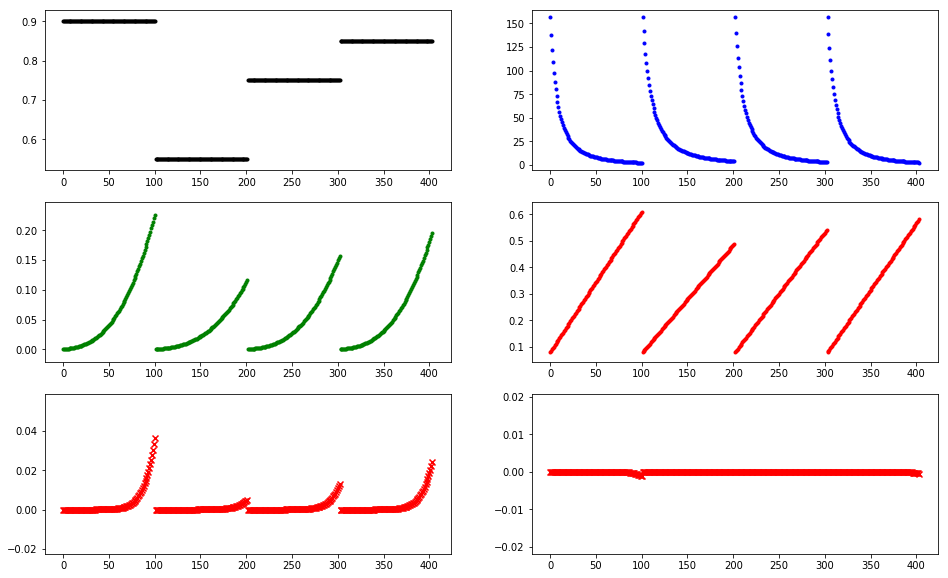

In [10]:
#big()
small()

** 查看数据的相关性 **

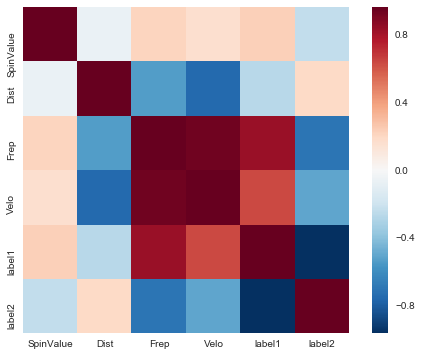

In [11]:
import seaborn as sns
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

由上图可以看出，速度（Velo）和Frep（频率）的相关性较高，所以这两个特征可以选择其一

## 预测到达无穷远的能流

-  label1

** 数据预处理 **

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
df['SpinValue'] = min_max_scaler.fit_transform(df.SpinValue.values.reshape(-1,1))
df['Dist'] = min_max_scaler.fit_transform(df.Dist.values.reshape(-1,1))
df['Frep'] = min_max_scaler.fit_transform(df.Frep.values.reshape(-1,1))


N = df['SpinValue'].shape[0]
data = np.zeros((N, 3))
data[:,0] = df['SpinValue']
data[:,1] = df['Dist']
data[:,2] = df['Frep']
y = min_max_scaler.fit_transform(df.label1.values.reshape(-1,1))

In [13]:
data

array([[  1.00000000e+00,   9.99878694e-01,   0.00000000e+00],
       [  1.00000000e+00,   8.77902085e-01,   4.81700921e-04],
       [  1.00000000e+00,   7.76649266e-01,   1.02697399e-03],
       ..., 
       [  8.57142857e-01,   2.74686804e-03,   8.21863814e-01],
       [  8.57142857e-01,   2.38011670e-03,   8.43743682e-01],
       [  8.57142857e-01,   2.02220977e-03,   8.66007418e-01]])

In [25]:
y

array([[  0.00000000e+00],
       [  1.66325400e-09],
       [  4.55737973e-09],
       [  9.43250067e-09],
       [  1.74107349e-08],
       [  3.01336229e-08],
       [  4.99549866e-08],
       [  8.01896462e-08],
       [  1.25430076e-07],
       [  1.91944893e-07],
       [  2.88175055e-07],
       [  4.25345785e-07],
       [  6.18214576e-07],
       [  8.85978139e-07],
       [  1.25336386e-06],
       [  1.75193432e-06],
       [  2.42163604e-06],
       [  3.31262866e-06],
       [  4.48744108e-06],
       [  6.02342815e-06],
       [  8.01578553e-06],
       [  1.05808197e-05],
       [  1.38598822e-05],
       [  1.80238169e-05],
       [  2.32780541e-05],
       [  2.98684157e-05],
       [  3.80877042e-05],
       [  4.82831615e-05],
       [  6.08648848e-05],
       [  7.63152973e-05],
       [  9.51997749e-05],
       [  1.18178543e-04],
       [  1.46019959e-04],
       [  1.79615313e-04],
       [  2.19995273e-04],
       [  2.68348136e-04],
       [  3.26040029e-04],
 

** 数据分为训练集和测试集 **

In [14]:
Ntrain = int(N*0.80)
Xtrain = data[:Ntrain]
ytrain = y[:Ntrain]

Xtest = data[Ntrain:]
ytest = y[Ntrain:]

### 传统机器学习模型

In [58]:
def models(regs):
    for regression in regs:
        t0 = time.time()
        model = regression()
        model = model.fit(Xtrain, ytrain)
        print("run time = %0.2f s" % (time.time() - t0))
        ypred=model.predict(Xtest)
        
        acc = model.score(Xtest, ytest)
        print(regression.__name__ + " accur = %f" % acc)
        newp = min_max_scaler.inverse_transform(ypred)
        newy_test = min_max_scaler.inverse_transform(ytest)
        plt.plot(newp, color='red', label='Prediction')
        plt.plot(newy_test,color='blue', label='Actual')
        plt.legend(loc='best')
        plt.title('The test result for {}'.format(regression.__name__))
        plt.ylabel('label1')
        plt.show()

run time = 0.00 s
KNeighborsRegressor accur = 0.997316


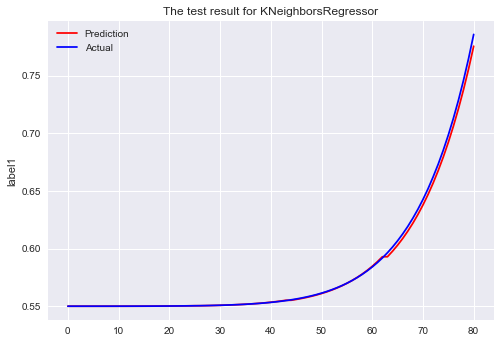

run time = 0.00 s
DecisionTreeRegressor accur = 0.987622


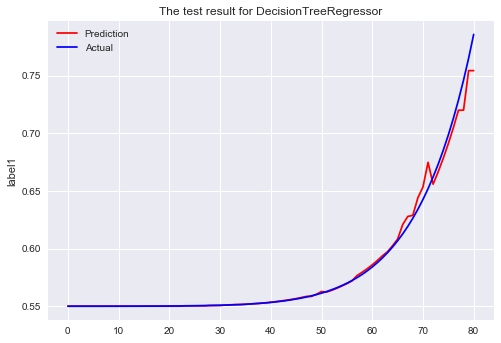

run time = 0.01 s
RandomForestRegressor accur = 0.991814


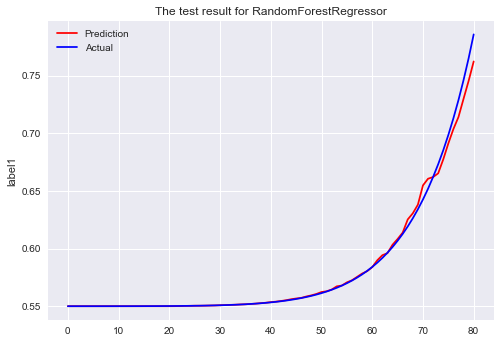

run time = 0.00 s
LinearRegression accur = 0.785782


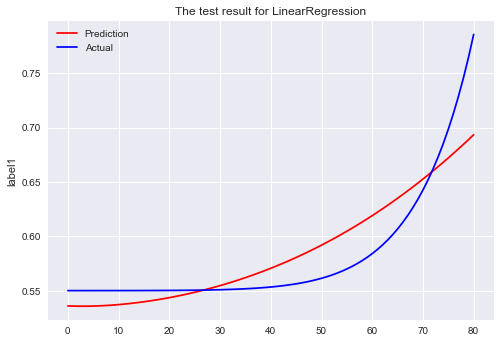

run time = 0.00 s
SVR accur = 0.789590


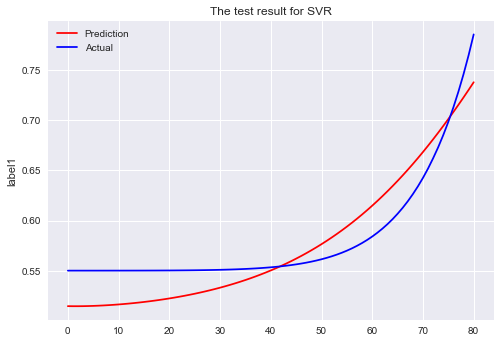

In [59]:
regs = ((KNeighborsRegressor), (tree.DecisionTreeRegressor), (RandomForestRegressor),(LinearRegression),(svm.SVR))
models(regs)

** 查看相对误差 **

In [108]:
def models(regs):
    for regression in regs:
        t0 = time.time()
        model = regression()
        model = model.fit(Xtrain, ytrain)
        print("run time = %0.2f s" % (time.time() - t0))
        ypred=model.predict(Xtest).reshape(81,1)
       
        acc = model.score(Xtest, ytest)
        print(regression.__name__ + " accur = %f" % acc)
        newp = min_max_scaler.inverse_transform(ypred)
        newy_test = min_max_scaler.inverse_transform(ytest)
        new = (newy_test-newp)/newy_test
        plt.plot(new)
        plt.show()

run time = 0.00 s
KNeighborsRegressor accur = 0.997316


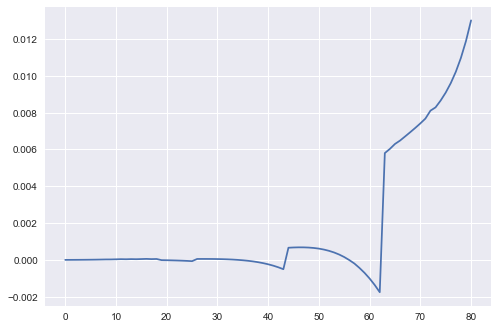

run time = 0.00 s
DecisionTreeRegressor accur = 0.991252


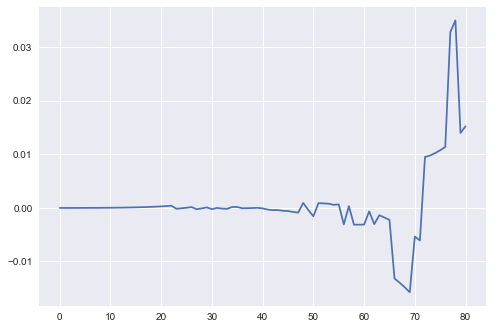

run time = 0.01 s
RandomForestRegressor accur = 0.991684


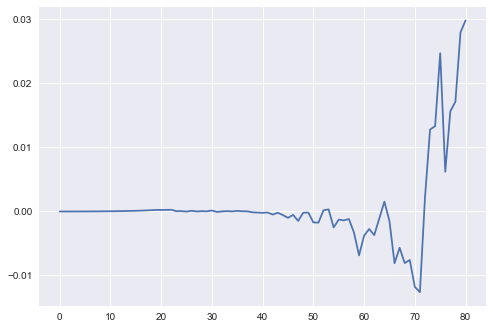

run time = 0.00 s
LinearRegression accur = 0.785782


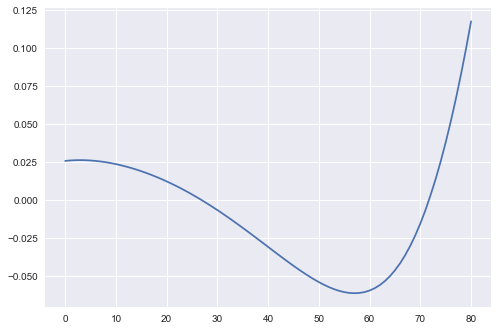

run time = 0.00 s
SVR accur = 0.789590


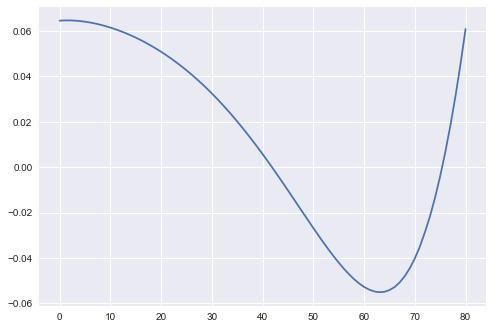

In [109]:
regs = ((KNeighborsRegressor), (tree.DecisionTreeRegressor), (RandomForestRegressor),(LinearRegression),(svm.SVR))
models(regs)

## 预测到达黑洞视界的能流

- label2

** 数据预处理 **

In [170]:
min_max_scaler = preprocessing.MinMaxScaler()
df['SpinValue'] = min_max_scaler.fit_transform(df.SpinValue.values.reshape(-1,1))
df['Dist'] = min_max_scaler.fit_transform(df.Dist.values.reshape(-1,1))
df['Frep'] = min_max_scaler.fit_transform(df.Frep.values.reshape(-1,1))


N = df['SpinValue'].shape[0]
data = np.zeros((N, 3))
data[:,0] = df['SpinValue']
data[:,1] = df['Dist']
data[:,2] = df['Frep']
y = min_max_scaler.fit_transform(df.label2.values.reshape(-1,1))

** 数据分为训练集和测试集 **

In [171]:
Ntrain = int(N*0.80)
Xtrain = data[:Ntrain]
ytrain = y[:Ntrain]

Xtest = data[Ntrain:]
ytest = y[Ntrain:]

### 传统机器学习模型

In [172]:
def models(regs):
    for regression in regs:
        t0 = time.time()
        model = regression()
        model = model.fit(Xtrain, ytrain)
        print("run time = %0.2f s" % (time.time() - t0))
        ypred=model.predict(Xtest)
        
        rms = np.sqrt(np.mean((ytest - ypred) ** 2))
        print(regression.__name__ + " RMS error = %.2g" % rms)
        newp = min_max_scaler.inverse_transform(ypred)
        newy_test = min_max_scaler.inverse_transform(ytest)
        plt.plot(newp, color='red', label='Prediction')
        plt.plot(newy_test,color='blue', label='Actual')
        plt.legend(loc='best')
        plt.title('The test result for {}'.format(regression.__name__))
        plt.ylabel('label2')
        plt.show()

run time = 0.00 s
KNeighborsRegressor RMS error = 0.026


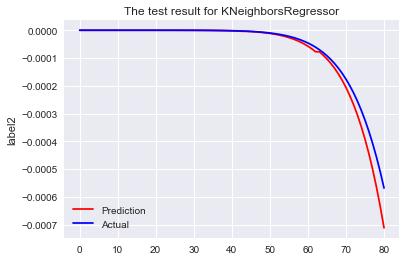

run time = 0.00 s
DecisionTreeRegressor RMS error = 0.16


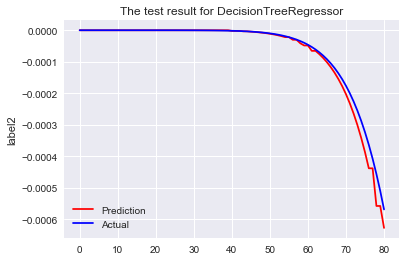

run time = 0.02 s
RandomForestRegressor RMS error = 0.16


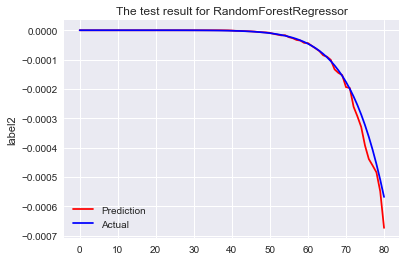

run time = 0.00 s
LinearRegression RMS error = 0.062


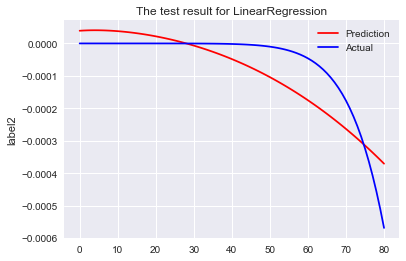

run time = 0.00 s
SVR RMS error = 0.18


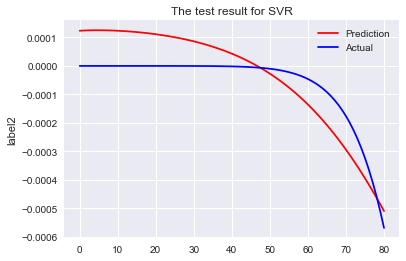

In [173]:
regs = ((KNeighborsRegressor), (tree.DecisionTreeRegressor), (RandomForestRegressor),(LinearRegression),(svm.SVR))
models(regs)